In [101]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def printVar (varname, var):

    print(varname)
    print(var)

def saveArray (name, array):

    pd.DataFrame(array).to_csv("savedVariables/" + name + ".csv", index=False, header=None)



In [102]:
# Solve the 2D Navier-Cauchy equation using a segregated finite volume method

# Define mesh geometry and boundary conditions

Lx = .01 #width of domain
Ly = .01 #height of domain

fac = 1

tr_left_x = -1e-6*fac      #u boundary condition at the left boundary
tr_left_y =  1e-6*0     #v boundary condition at the left boundary

tr_right_x = +1e-6*fac    #u boundary condition at the right boundary
tr_right_y = 1e-6*0     #v boundary condition at the right boundary

tr_top_x = 1e-6*0       #u boundary condition at the top boundary
tr_top_y = +1e-6*fac       #v boundary condition at the top boundary

tr_bottom_x = -1e-6*0    #u boundary condition at the bottom boundary 
tr_bottom_y = -1e-6*fac    #v boundary condition at the bottom boundary

nx = 8          #number of control volumes in the x-direction
ny = 8            #number of control volumes in the y-direction


In [103]:
sys.path.append("../Classes/")

from index_and_direction import dim

# dim().nx = 9
# dim().ny = 9

# print(dim().nx)

In [104]:
print(dim().nx)

8


In [105]:
from index_and_direction import index
from index_and_direction import boundary_point_index
from index_and_direction import cell_index
from index_and_direction import displacement

In [106]:
# Define material properties

rho = 8050         #density of steel in kg/m^3
mu = 78*10e9       #shear modulus in Pa
K = 1.6*10e11      #bulk modulus in Pa

Lambda = K - (2/3)*mu

#print(Lambda)

In [107]:
## Define required variables

tf = 0.01           #total time in seconds
dx = Lx/nx          #length of each control volume in the x-direction
dy = Ly/ny          #length of each control volume in the y-direction
dt = tf/10          #size of time steps
Sfx = dy            #area vector x component (Area of East and West Faces)
Sfy = dx            #area vector y component (Area of North and South Faces)


In [108]:
## Define  position and time vectors

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
x = np.zeros((1,nx+2))   #position vector defining the center points of the control volumes in the x-direction.
x[0,nx+1] = Lx
x[0,1:nx+1] = np.arange(dx/2,Lx,dx)

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
y = np.zeros((1,ny+2))   #position vector defining the center points of the control volumes in the y-direction.
y[0,ny+1] = Ly
y[0,1:ny+1] = np.arange(dy/2,Ly,dy)

In [109]:
## Define required displacement matrices and b vector

u_new = np.zeros([(ny+2)*(nx+2),2])         #unknown displacements at t + 1    (Column 1 = x, Column2 = y)
u_old = np.zeros([(ny+2)*(nx+2),2])         #displacement at time t
u_old_old = np.zeros([(ny+2)*(nx+2),2])     #displacement at time t - 1

#rhs vector
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

## X equation:

In [110]:
class A:

    val = "value that stays in class without changning with instance"

    def __init__(self, xy):

        if xy == "x":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfx)/dx + ((2*mu)*Sfy)/dy
            self.a_N = ((mu)*Sfy)/dy
            self.a_S = ((mu)*Sfy)/dy
            self.a_E = ((2*mu + Lambda)*Sfx)/dx
            self.a_W = ((2*mu + Lambda)*Sfx)/dx

        if xy == "y":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfy)/dy + ((2*mu)*Sfx)/dx 
            self.a_N = ((2*mu + Lambda)*Sfy)/dy
            self.a_S = ((2*mu + Lambda)*Sfy)/dy
            self.a_E = ((mu)*Sfx)/dx
            self.a_W = ((mu)*Sfx)/dx          

    def createMatrix(self):

        A_no_boundary = np.zeros([(ny+2)*(nx+2), (ny+2)*(nx+2)])
        # A_no_boundary = csr_matrix(A_no_boundary)  

        for j in np.arange(2, ny):     

            for k in np.arange((j*(nx+2)+2), (j*(nx+2)+nx)):  
                
                A_no_boundary[k,k] = self.a_P
                A_no_boundary[k,k+nx+2] = -self.a_N
                A_no_boundary[k,k-nx-2] = -self.a_S
                A_no_boundary[k,k+1] = -self.a_E
                A_no_boundary[k,k-1] = -self.a_W
            
        return A_no_boundary






In [ ]:
# North diffusion term :

# Sn*( coeff_n_1*dv/dx + coeff_n_2*du/dy )

In [111]:
! mkdir hello

mkdir: cannot create directory ‘hello’: File exists


In [112]:
## Time loop

!rm -r savedVariables
! mkdir savedVariables

for time in t:

    print("\nTime = " + str(time))
    
    # Set number of maximum iterations for convergence
    
    icorr = 1
    maxcorr = 100000

    # Make directory

    ! mkdir savedVariables/{time}
    
    while True:
    # for iteration in [1]:
            
        u_previous = u_new #store latest guess values

        A_x = A("x").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # k is the cell number

            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)

            #Bottom left corner coefficients
               
            if cell_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,k+nx+2] = -(Sfy/dy)*mu

                #ae
                A_x[k,k+1] = - (Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                + V.NE
                                                + V.E
                                                + V.P
                                                + V.N
                                                - 2*V.NW #l
                                                - 2*V.W #l
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    + V.NE
                                                    + V.N
                                                    + V.P
                                                    + V.E
                                                    - 2*V.SE #b
                                                    - 2*V.S #b
                                                )
                            +
                            Sfy*tr_bottom_x
                            +
                            Sfx*tr_left_x
                        )   

            #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,k+nx+2] = -(Sfy/dy)*mu

                #aw
                A_x[k,k-1] = -(Sfx/dx)*(2*mu + Lambda)

                #b_x = A + B(u_b) + C(u_r) + D(-V.W -V.NW + 2v_r) + E(-V.N -V.NW + 2v_b)


                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                + 2*V.NE #r
                                                + 2*V.E #r
                                                - V.NW
                                                - V.W
                                                - V.P
                                                - V.N
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    - V.N
                                                    - V.NW
                                                    - V.P
                                                    - V.W
                                                    + 2*V.S #b
                                                    + 2*V.SW #b
                                                )
                            +
                            Sfx*tr_right_x
                            +
                            Sfy*tr_bottom_x
                        ) 

            # Top Left Corner Coeficients
                
            elif  cell_index().top_left_corner(k):

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)
                
                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #ae                
                A_x[k,k+1] = -(Sfx/dx)*(2*mu + Lambda)
                
                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                - V.E
                                                - V.SE
                                                - V.P
                                                - V.S
                                                + 2*V.W #l
                                                + 2*V.SW #l
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    + 2*V.NE #t
                                                    + 2*V.N #t
                                                    - V.P
                                                    - V.E
                                                    - V.SE
                                                    - V.S
                                                )
                            +
                            Sfy*tr_top_x
                            +
                            Sfx*tr_left_x
                        )
                
            # Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #aw
                A_x[k,k-1] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                - 2*V.E #r
                                                - 2*V.SE #r
                                                + V.W
                                                + V.SW
                                                + V.P
                                                + V.S
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    - 2*V.N #t
                                                    - 2*V.NW #t
                                                    + V.S
                                                    + V.SW
                                                    + V.P
                                                    + V.W
                                                )
                            +
                            Sfy*tr_top_x
                            +
                            Sfx*tr_right_x
                        )
                
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda) + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,k+nx+2] = -(Sfy/dy)*mu
                
                #ae
                A_x[k,k+1] = -(Sfx/dx)*(2*mu + Lambda)

                #aw
                A_x[k,k-1] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                + V.NE
                                                + V.E
                                                - V.NW
                                                - V.W
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    + V.NE
                                                    + V.N
                                                    + V.E
                                                    + V.P
                                                    - 2*V.SE #b
                                                    - 2*V.S #b
                                                )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    - V.N
                                                    - V.NW
                                                    - V.P
                                                    - V.W
                                                    + 2*V.S #b
                                                    + 2*V.SW #b
                                                )
                            +
                            Sfy*tr_bottom_x
                        )                                 

            # Center Top Boundaries

            elif cell_index().center_top(k):

                # #print(k)

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda) + (Sfx/dx)*(2*mu + Lambda)

                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu
                
                #ae
                A_x[k,k+1] = -(Sfx/dx)*(2*mu + Lambda)

                #aw
                A_x[k,k-1] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                - V.E
                                                - V.SE
                                                + V.W
                                                + V.SW
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    + 2*V.NE #t
                                                    + 2*V.N #t
                                                    - V.E
                                                    - V.P
                                                    - V.SE
                                                    - V.S
                                                )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                    - 2*V.N #t
                                                    - 2*V.NW #t
                                                    + V.P
                                                    + V.W
                                                    + V.S
                                                    + V.SW
                                                )
                            +
                            Sfy*tr_top_x
                        )
            
            # Center Left Boundaries

            elif  cell_index().center_left(k):

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,k+nx+2] = -(Sfy/dy)*mu
                
                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #ae
                A_x[k,k+1] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                + V.NE
                                                + V.E
                                                + V.N
                                                + V.P
                                                - 2*V.NW #l
                                                - 2*V.W #l
                                            )
                            +
                            (Sfy/(4*dx))*mu*(
                                                - V.E
                                                - V.SE
                                                - V.P
                                                - V.S
                                                + 2*V.W #l
                                                + 2*V.SW #l 
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                   + V.NE
                                                   + V.N
                                                   - V.SE
                                                   - V.S
                                                )
                            +
                            Sfx*tr_left_x
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,k+nx+2] = -(Sfy/dy)*mu
                
                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #aw
                A_x[k,k-1] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            +
                            (Sfy/(4*dx))*mu*(
                                                + 2*V.NE #r
                                                + 2*V.E #r
                                                - V.N
                                                - V.P
                                                - V.NW 
                                                - V.W 
                                            )
                            +
                            (Sfy/(4*dx))*mu*(
                                                - 2*V.E #r
                                                - 2*V.SE #r
                                                + V.P
                                                + V.S
                                                + V.W 
                                                + V.SW 
                                            )
                            +
                            (Sfx/(4*dy))*Lambda*(
                                                   - V.N 
                                                   - V.NW
                                                   + V.S
                                                   + V.SW
                                                )
                            +
                            Sfx*tr_right_x
                        )

            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):

                #print(str(k) +  ": Bottom points")

                #ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,k+nx+2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        (mu/(2*dx))*(
                                        + V.E
                                        - V.W
                                    )
                        ) 

            # Center Top

            elif boundary_point_index().center_top(k):
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        (mu/(2*dx))*(
                                        - V.E
                                        + V.W
                                    )
                        ) 

                
            # Center Left

            elif boundary_point_index().center_left(k):

                #print( str(k) + ": Left points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k,k+1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        (Lambda/(2*dy))*(
                                        + V.N
                                        - V.S
                                    )
                        )

            # Center Right

            elif boundary_point_index().center_right(k):

                #print( str(k) + ": Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k,k-1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        (Lambda/(2*dy))*(
                                        - V.N
                                        + V.S
                                    )
                        )

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                # print( str(k) + ": Bottom Left: Bottom points" )
                
                # ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,k+nx+2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        ((mu)/(2*dx))*(
                                        + V.E
                                        + V.P
                                        - 2*V.W
                                    )
                        ) 

            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k,k+1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k,k-1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                        - V.N
                                        - V.P
                                        + 2*V.S
                                    )
                        )

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,k+nx+2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        ((mu)/(2*dx))*(
                                        + V.E
                                        + V.P
                                        - 2*V.W
                                    )
                        )

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k,k+1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                        - V.E
                                        - V.P
                                        + 2*V.W
                                    )
                        )

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k,k-1] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                                - V.N
                                                - V.P
                                                + 2*V.S
                                            )
                        )

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                            - V.E
                                            - V.P
                                            + 2*V.W
                                    )
                        ) 
            # Corner Points

            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).ne] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["n", "ne"])] = 1
                A_x[k,index(k).dir(["ne", "ne"])] = 1
                A_x[k,index(k).dir(["e", "ne"])] = 1

                b_x[k] = 0

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).nw] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["n", "nw"])] = 1
                A_x[k,index(k).dir(["nw", "nw"])] = 1
                A_x[k,index(k).dir(["w", "nw"])] = 1

                b_x[k] = 0

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).se] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["s", "se"])] = 1
                A_x[k,index(k).dir(["se", "se"])] = 1
                A_x[k,index(k).dir(["e", "se"])] = 1

                b_x[k] = 0

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).sw] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["s", "sw"])] = 1
                A_x[k,index(k).dir(["sw", "sw"])] = 1
                A_x[k,index(k).dir(["w", "sw"])] = 1

                b_x[k] = 0
                
            else:

                # print(str(k) + ": NO BC Cell")

                b_x[k] = (
                            (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy)
                            + (Sfy/(4*dx))*mu*(
                                                + V.NE    # + V.Ne
                                                - V.NW    # - V.NW
                                                - V.SE    # - V.SE
                                                + V.SW    # + V.SW
                                            )
                            +(Sfx/(4*dy))*Lambda*(
                                                    + V.NE    # + V.Ne
                                                    - V.NW    # - V.NW
                                                    - V.SE    # - V.SE
                                                    + V.SW    # + V.SW 
                                                )
                            )

        # saveArray(str(time) + "/A_x_" + str(icorr) , A_x.todense())   
        # saveArray(str(time) + "/b_x_" + str(icorr), b_x)  

        ## Solve the x-equation
        
        Ux = spsolve(A_x, b_x)
        Ux = np.array(Ux)

        # #print(Ux)

        saveArray(str(time) + "/Ux_" + str(icorr), Ux)
        
        ## Prepare matrix A and b vector for the y-equation
        
        A_y = A("y").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number


            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)
 
            #Bottom left corner coefficients
            
            if cell_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom left corner coefficients")
                
                #ap
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu)    
                
                #an
                A_y[k,k+nx+2] = -(Sfy/dy)*(2*mu + Lambda)

                #ae                
                A_y[k,k+1] = -(Sfx/dx)*(mu)
                
                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                + U.NE
                                                + U.E
                                                + U.P
                                                + U.N
                                                - 2*U.NW #l
                                                - 2*U.W #l
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    + U.NE
                                                    + U.N
                                                    + U.P
                                                    + U.E
                                                    - 2*U.SE #b
                                                    - 2*U.S #b
                                                )
                            +
                            Sfy*tr_bottom_y
                            +
                            Sfx*tr_left_y
                        )
                
            #Bottom right corner coefficients

            elif  cell_index().bottom_right_corner(k):
                
                #print(str(k) + ": Bottom right corner coefficients")
               
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu)    
                
                #an
                A_y[k,k+nx+2] = -(Sfy/dy)*(2*mu + Lambda)

                #aw                
                A_y[k,k-1] = -(Sfx/dx)*(mu)
                
                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                + 2*U.NE #r
                                                + 2*U.E #r
                                                - U.NW
                                                - U.W
                                                - U.P
                                                - U.N
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    - U.N
                                                    - U.NW
                                                    - U.P
                                                    - U.W
                                                    + 2*U.S #b
                                                    + 2*U.SW #b
                                                )
                            +
                            Sfy*tr_bottom_y
                            +
                            Sfx*tr_right_y
                        )
                     
            #Top left corner coefficients
                
            elif  cell_index().top_left_corner(k):

                #print(str(k) + ":Top Left corner coefficients")

                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu)    
                
                #as
                A_y[k,k-nx-2] = -(Sfy/dy)*(2*mu + Lambda)

                #ae                
                A_y[k,k+1] = -(Sfx/dx)*(mu)
                
                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                    - U.E
                                                    - U.SE
                                                    - U.P
                                                    - U.S
                                                    + 2*U.W #l
                                                    + 2*U.SW #l
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    + 2*U.NE #t
                                                    + 2*U.N #t
                                                    - U.P
                                                    - U.E
                                                    - U.SE
                                                    - U.S
                                                )
                            +
                            Sfy*tr_top_y
                            +
                            Sfx*tr_left_y
                        )    
                
            #Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   

                #print(str(k) + ":Top right corner coefficients")

                #ap
                
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu)    
                
                #as
                A_y[k,k-nx-2] = -(Sfy/dy)*(2*mu + Lambda)

                #aw                
                A_y[k,k-1] = -(Sfx/dx)*(mu)
                
                b_y[k] = (
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                    - 2*U.E #r
                                                    - 2*U.SE #r
                                                    + U.W
                                                    + U.SW
                                                    + U.P
                                                    + U.S
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    - 2*U.N #t
                                                    - 2*U.NW #t
                                                    + U.S
                                                    + U.SW
                                                    + U.P
                                                    + U.W
                                                )
                            +
                            Sfy*tr_top_y
                            +
                            Sfx*tr_right_y
                        )
            
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):

                #print(str(k) + ": Bottom Center Coefficents for Cell")


                #ap
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu) + (Sfx/dx)*(mu)

                #an
                A_y[k,k+nx+2] = -(Sfy/dy)*(2*mu + Lambda)
                
                #ae
                A_y[k,k+1] = -(Sfx/dx)*(mu)

                #aw
                A_y[k,k-1] = -(Sfx/dx)*(mu)

                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                + U.NE
                                                + U.E
                                                - U.NW
                                                - U.W
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    + U.NE
                                                    + U.N
                                                    + U.E
                                                    + U.P
                                                    - 2*U.SE #b
                                                    - 2*U.S #b
                                                )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    - U.N
                                                    - U.NW
                                                    - U.P
                                                    - U.W
                                                    + 2*U.S #b
                                                    + 2*U.SW #b
                                                )
                            +
                            Sfy*tr_bottom_y
                        )

            # Center Top Boundaries

            elif cell_index().center_top(k):

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*(mu) + (Sfx/dx)*(mu)

                #as
                A_y[k,k-nx-2] = -(Sfy/dy)*(2*mu + Lambda)
                
                #ae
                A_y[k,k+1] = -(Sfx/dx)*(mu)

                #aw
                A_y[k,k-1] = -(Sfx/dx)*(mu)

                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                - U.E
                                                - U.SE
                                                + U.W
                                                + U.SW
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    + 2*U.NE #t
                                                    + 2*U.N #t
                                                    - U.E
                                                    - U.P
                                                    - U.SE
                                                    - U.S
                                                )
                            +
                            (Sfx/(4*dy))*mu*(
                                                    - 2*U.N #t
                                                    - 2*U.NW #t
                                                    + U.P
                                                    + U.W
                                                    + U.S
                                                    + U.SW
                                                )
                            +
                            Sfy*tr_top_y
                        )

            # Center Left Boundaries

            elif  cell_index().center_left(k):

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*mu

                #an
                A_y[k,k+nx+2] = -(Sfy/dy)*(2*mu + Lambda)
                
                #as
                A_y[k,k-nx-2] = -(Sfy/dy)*(2*mu + Lambda)

                #ae
                A_y[k,k+1] = -(Sfx/dx)*(mu)

                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy) 
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                + U.NE
                                                + U.E
                                                + U.N
                                                + U.P
                                                - 2*U.NW #l
                                                - 2*U.W #l
                                            )
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                - U.E
                                                - U.SE
                                                - U.P
                                                - U.S
                                                + 2*U.W #l
                                                + 2*U.SW #l 
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                   + U.NE
                                                   + U.N
                                                   - U.SE
                                                   - U.S
                                                )
                            +
                            Sfx*tr_left_y
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_y[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*(2*mu + Lambda) + (Sfy/dy)*(2*mu + Lambda) + (Sfx/dx)*mu

                #an
                A_y[k,k+nx+2] = -(Sfy/dy)*(2*mu + Lambda)
                
                #as
                A_y[k,k-nx-2] = -(Sfy/dy)*(2*mu + Lambda)

                #aw
                A_y[k,k-1] = -(Sfx/dx)*(mu)

                b_y[k] =(
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                + 2*U.NE #r
                                                + 2*U.E #r
                                                - U.N
                                                - U.P
                                                - U.NW 
                                                - U.W 
                                            )
                            +
                            (Sfy/(4*dx))*Lambda*(
                                                - 2*U.E #r
                                                - 2*U.SE #r
                                                + U.P
                                                + U.S
                                                + U.W
                                                + U.SW 
                                            )
                            +
                            (Sfx/(4*dy))*mu*(
                                                   - U.N 
                                                   - U.NW
                                                   + U.S
                                                   + U.SW
                                                )
                            +
                            Sfx*tr_right_y
                        )


            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):

                #print(str(k) +  ": Bottom points")

                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,k+nx+2] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        (Lambda/(2*dx))*(
                                        + U.E
                                        - U.W
                                    )
                        ) 

            # Center Top

            elif boundary_point_index().center_top(k):
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,k-nx-2] = - (4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        (Lambda/(2*dx))*(
                                        - U.E
                                        + U.W
                                    )
                        ) 
                
            # Center Left

            elif boundary_point_index().center_left(k):

                #print( str(k) + ": Left points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k,k+1] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        (mu/(2*dy))*(
                                        + U.N
                                        - U.S
                                    )
                        )

            # Center Right

            elif boundary_point_index().center_right(k):

                #print( str(k) + ": Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k,k-1] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        (mu/(2*dy))*(
                                        - U.N
                                        + U.S
                                    )
                        )

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                #print( str(k) + ": Bottom Left: Bottom points" )
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dx      

                #an
                A_y[k,k+nx+2] = -(4*mu + 2*Lambda)/dx

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((mu)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        ) 
            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k,k+1] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k,k-1] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,k+nx+2] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((Lambda)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        )

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_y[k,k] = 2*mu/dx

                #ae
                A_y[k,k+1] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,k-nx-2] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        )

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_y[k,k] =  2*mu/dx

                #aw
                A_y[k,k-1] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_y[k,k] = (4*Lambda + 2*mu)/dy

                #as
                A_y[k,k-nx-2] = -(4*Lambda + 2*mu)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        ) 
            # # Corner Points
            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).ne] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["n", "ne"])] = 1
                A_y[k,index(k).dir(["ne", "ne"])] = 1
                A_y[k,index(k).dir(["e", "ne"])] = 1

                b_y[k] = 0

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).nw] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["n", "nw"])] = 1
                A_y[k,index(k).dir(["nw", "nw"])] = 1
                A_y[k,index(k).dir(["w", "nw"])] = 1

                b_y[k] = 0

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).se] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["s", "se"])] = 1
                A_y[k,index(k).dir(["se", "se"])] = 1
                A_y[k,index(k).dir(["e", "se"])] = 1

                b_y[k] = 0

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).sw] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["s", "sw"])] = 1
                A_y[k,index(k).dir(["sw", "sw"])] = 1
                A_y[k,index(k).dir(["w", "sw"])] = 1

                b_y[k] = 0
            
            # Corner Points
            # elif boundary_point_index().bottom_left_corner(k):

            #     #print(str(k) + ": Bottom Left Corner Point on Boundary")

            #     A_y[k,k] = 1
            #     b_y[k] = 1e-16

            # elif boundary_point_index().bottom_right_corner(k):
            #     #print(str(k) + ": Bottom Right Corner Point on Boundary")
            #     A_y[k,k] = 1
            #     b_y[k] = 1e-16

            # elif boundary_point_index().top_left_corner(k):
            #     #print(str(k) + ": Top Left Corner Point on Boundary")
            #     A_y[k,k] = 1
            #     b_y[k] = 1e-16

            # elif boundary_point_index().top_right_corner(k):
            #     #print(str(k) + ": Top Right Corner Point on Boundary")
            #     A_y[k,k] = 1
            #     b_y[k] = 1e-16

            else:

                #print(str(k) + ": NO BC Cell")

                b_y[k] = (
                            (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
                            + (Sfy/(4*dx))*Lambda*(
                                                + U.NE    # + U.Ne
                                                - U.NW    # - U.Nw
                                                - U.SE    # - U.Se
                                                + U.SW    # + U.Sw
                                            )
                            +(Sfx/(4*dy))*mu*(
                                                    + U.NE    # + U.Ne
                                                    - U.NW    # - U.Nw
                                                    - U.SE    # - U.Se
                                                    + U.SW    # + U.Sw 
                                                )
                            )
        # saveArray(str(time) + "/A_y_" + str(icorr) , A_y)
        # saveArray(str(time) + "/b_y_" + str(icorr), b_y)       
                
        ## Solve the y-equation
        Uy = spsolve(A_y, b_y)
        Uy = np.array(Uy)

        saveArray(str(time) + "/Uy_" + str(icorr), Uy)
        
        # ## Update U.New with new x and y displacements

        u_new1 = np.vstack((Ux, Uy)).T
        saveArray (str(time) + "/U_new1_" + str(icorr), u_new1)    
        saveArray (str(time) + "/u_previous_" + str(icorr), u_previous)

        # # U.New[:,0] = Ux
        # # U.New[:,1] = Uy
        
        ## Calculate the residual of each iteration
        
        normFactor = np.max(u_new1)
        residual = math.sqrt(np.mean((u_new1 - u_previous)**2))/normFactor
        tolerance = 1e-3

        u_new = u_new1
    
        ##print out residual of each iteration
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))
             
        ## Convergence check
        
        if residual < tolerance:
            
            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1
    
    ## Update variables
    
    u_old_old = u_old
    u_old = u_new1
    
    # ## Add the boundary conditions to the solution matrices
    u_reshape_x = u_new[:,0].reshape(nx+2, ny+2)
    u_reshape_y = u_new[:,1].reshape(nx+2, ny+2)
    
    # #Boundary conditions for u matrix
    U = np.zeros((nx+2,ny+2))
    V = np.zeros((nx+2,ny+2))
 
    U[:, :] = u_reshape_x
    V[:, :] = u_reshape_y 

    #Modulus of displacement

    disp_mod = np.sqrt((U**2) + (V**2))
    disp_mod_converted = disp_mod*1e6 #Convert displacement to micrometers
    
#     # ## Plot the results

    import plotly.graph_objects as go

    disp_mod = np.sqrt((U**2) + (V**2))*1e-10

    dispx, dispy = np.meshgrid(x, y)
    fig = go.Figure(data=[go.Surface(z=disp_mod_converted, x=dispx, y=dispy)])
    
fig.show()   

print("U graph")
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])

fig.show()   

print("V graph")
fig = go.Figure(data=[go.Surface(z=V, x=dispx, y=dispy)])

fig.show()   




Time = 0.0
icorr = 1, Residual = 0.67571795153166258618, normFactor = 0.00000000000000000000
icorr = 2, Residual = 0.46342160490108780246, normFactor = 0.00000000000000000000
icorr = 3, Residual = 0.14869673168875396918, normFactor = 0.00000000000000000000
icorr = 4, Residual = 0.06714255347592815171, normFactor = 0.00000000000000000000
icorr = 5, Residual = 0.02646713711938687361, normFactor = 0.00000000000000000000
icorr = 6, Residual = 0.01109371379740260212, normFactor = 0.00000000000000000000
icorr = 7, Residual = 0.00456225125866921780, normFactor = 0.00000000000000000000
icorr = 8, Residual = 0.00193317398640076863, normFactor = 0.00000000000000000000
icorr = 9, Residual = 0.00086150427584839287, normFactor = 0.00000000000000000000

Time = 0.001
icorr = 1, Residual = 0.00046037698277507716, normFactor = 0.00000000000000000000

Time = 0.002
icorr = 1, Residual = 0.00033217840239163719, normFactor = 0.00000000000000000000

Time = 0.003
icorr = 1, Residual = 0.00029862496926709415

U graph


V graph


(100, 100)


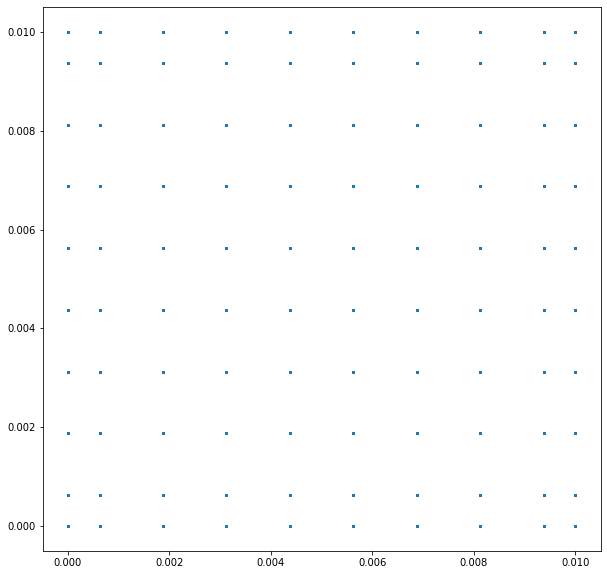

In [113]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))


# Displacement Scatter:

#
x_values = (dispx.reshape((nx+2)*(ny+2), 1) + u_new[:, 0])#*scale
y_values = (dispy.reshape((nx+2)*(ny+2), 1) + u_new[:, 1])#*scale

print(x_values.shape)

plt.scatter(x_values, y_values, s=1)

0 10
[[-1.32843093e-21]
 [ 6.25000000e-04]
 [ 1.87500000e-03]
 [ 3.12500000e-03]
 [ 4.37500000e-03]
 [ 5.62500000e-03]
 [ 6.87500000e-03]
 [ 8.12500000e-03]
 [ 9.37500000e-03]
 [ 1.00000000e-02]]
[[-1.32493569e-21]
 [-1.36442866e-21]
 [-1.34371154e-21]
 [-1.34389895e-21]
 [-1.34401274e-21]
 [-1.34468070e-21]
 [-1.34505558e-21]
 [-1.34441782e-21]
 [-1.32558722e-21]
 [-1.35077388e-21]]
10 20
[[-1.32843093e-21]
 [ 6.25000000e-04]
 [ 1.87500000e-03]
 [ 3.12500000e-03]
 [ 4.37500000e-03]
 [ 5.62500000e-03]
 [ 6.87500000e-03]
 [ 8.12500000e-03]
 [ 9.37500000e-03]
 [ 1.00000000e-02]]
[[-1.32493569e-21]
 [-1.36442866e-21]
 [-1.34371154e-21]
 [-1.34389895e-21]
 [-1.34401274e-21]
 [-1.34468070e-21]
 [-1.34505558e-21]
 [-1.34441782e-21]
 [-1.32558722e-21]
 [-1.35077388e-21]]
20 30
[[-1.32843093e-21]
 [ 6.25000000e-04]
 [ 1.87500000e-03]
 [ 3.12500000e-03]
 [ 4.37500000e-03]
 [ 5.62500000e-03]
 [ 6.87500000e-03]
 [ 8.12500000e-03]
 [ 9.37500000e-03]
 [ 1.00000000e-02]]
[[-1.32493569e-21]
 [-1.3644

array([[-1.32843093e-21],
       [ 6.25000000e-04],
       [ 1.87500000e-03],
       [ 3.12500000e-03],
       [ 4.37500000e-03],
       [ 5.62500000e-03],
       [ 6.87500000e-03],
       [ 8.12500000e-03],
       [ 9.37500000e-03],
       [ 1.00000000e-02]])

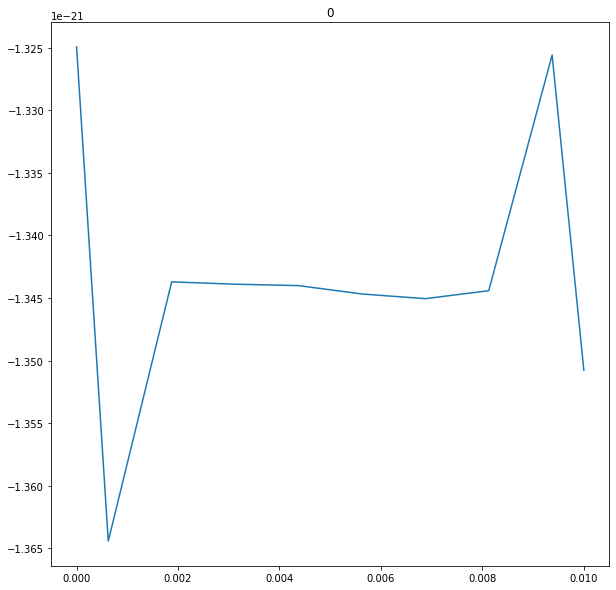

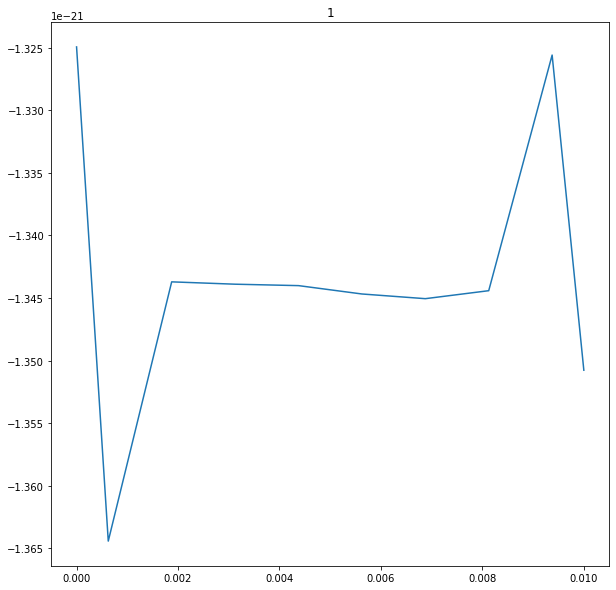

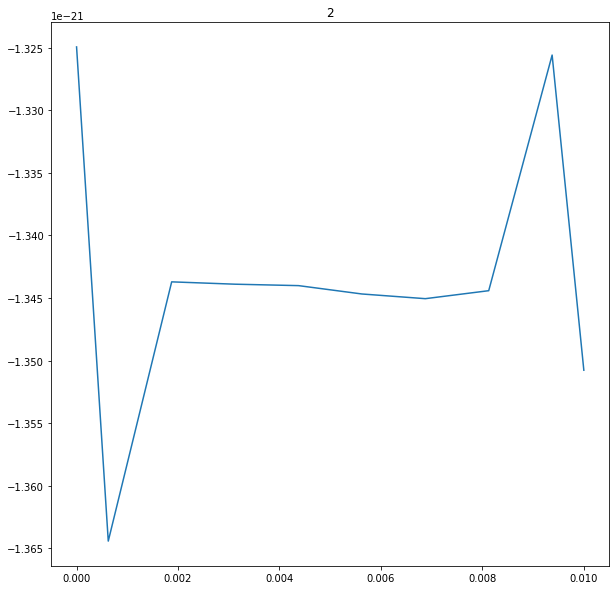

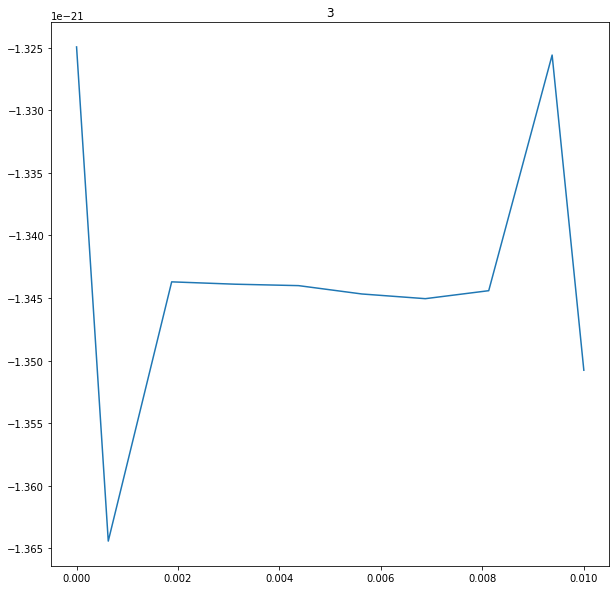

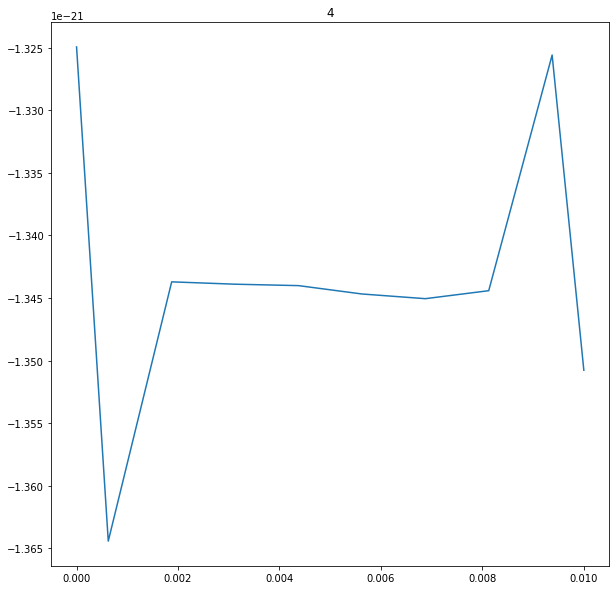

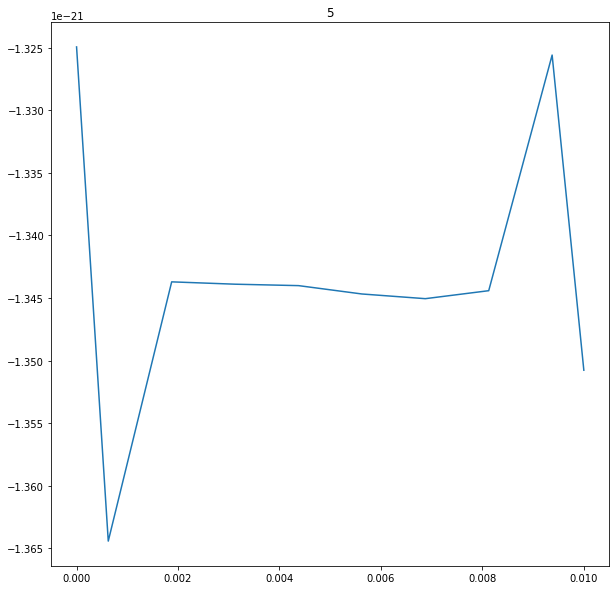

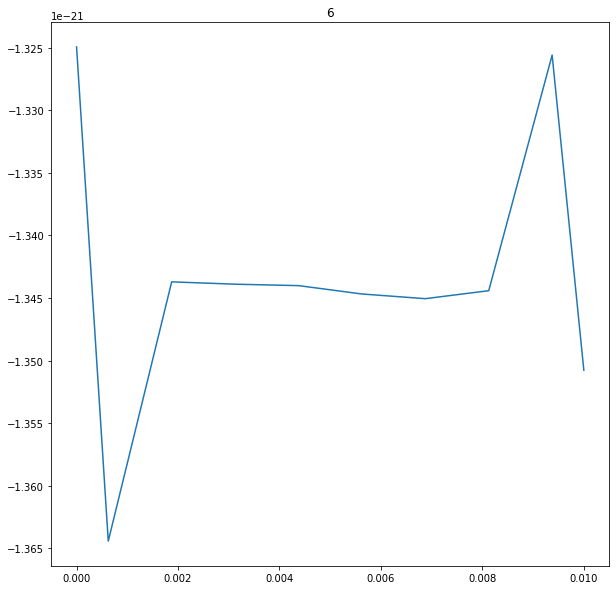

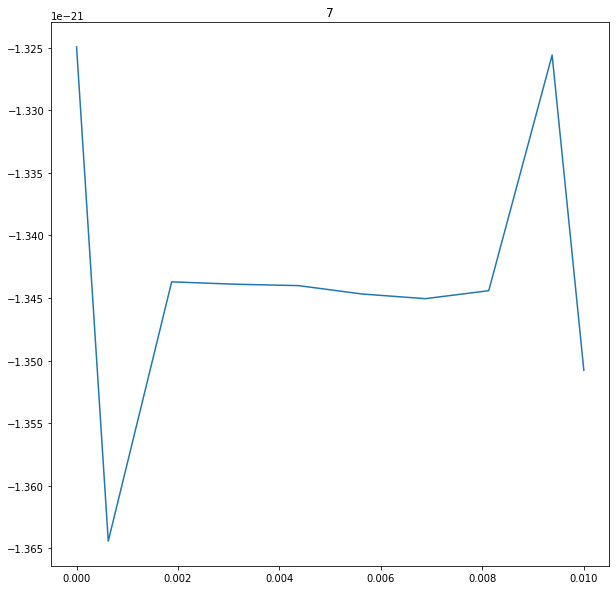

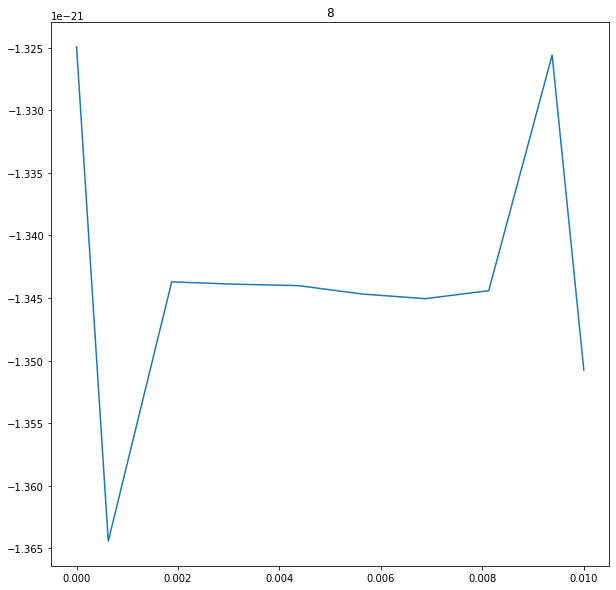

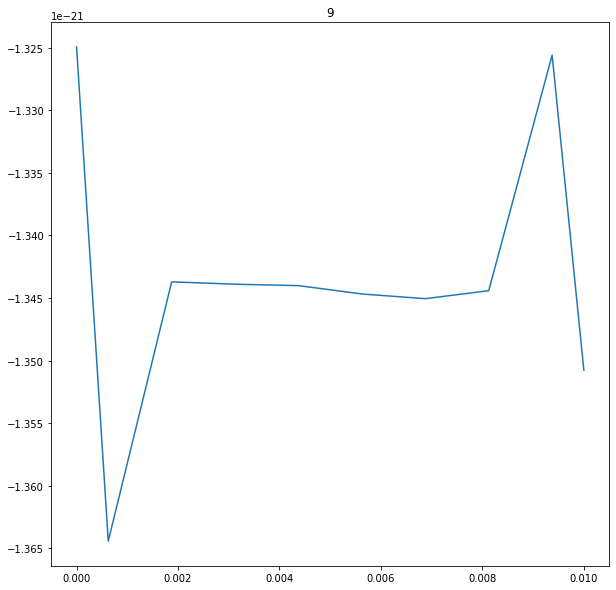

In [114]:
for i in np.arange(0,ny+2):
    
    plt.figure(figsize=(10, 10))

    print(str(0+(i*10)), str(10+(i*10)))
    
    x_values = dispx.reshape((nx+2)*(ny+2), 1)[0+(i*10):10+(i*10)] + u_new[:,0].reshape((nx+2)*(ny+2), 1)[0:10]

    y_values = u_new[:,1].reshape((nx+2)*(ny+2), 1)[0:10]

    plt.plot(x_values, y_values)
    plt.title(str(i))

    plt.show

x_values